In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv1D, TimeDistributed, Flatten,
                                     LSTM, Dense, Dropout, BatchNormalization,
                                     Embedding, Concatenate, Reshape)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(true_labels, pred_labels, title="Confusion Matrix"):
    labels = sorted(list(set(true_labels + pred_labels)))
    cm = confusion_matrix(true_labels, pred_labels, labels=labels)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

print("Imports og hjelpefunksjoner lastet.")


Imports og hjelpefunksjoner lastet.


In [2]:
file_path = "CSV_Library/baseline.csv"
data = pd.read_csv(file_path)
print("Original data shape:", data.shape)

if "movement" not in data.columns:
    raise ValueError("'movement' mangler i datasettet.")

data['movement'] = data['movement'].astype('category')
original_mapping = dict(enumerate(data['movement'].cat.categories))
data['movement'] = data['movement'].cat.codes
print("Movement mapping (original):", original_mapping)


o_code = None
for code, label_str in original_mapping.items():
    if label_str == 'O': 
        o_code = code
        break
print(f"Koden for 'O' i bevegelsene er: {o_code}")

def presence_func(mov_code):
    return 0 if mov_code == o_code else 1

data['presence'] = data['movement'].apply(presence_func)

print("Eksempel-fordeling av presence:")
print(data['presence'].value_counts())


Original data shape: (881357, 421)
Movement mapping (original): {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'O'}
Koden for 'O' i bevegelsene er: 9
Eksempel-fordeling av presence:
1    708450
0    172907
Name: presence, dtype: int64


In [3]:
amplitude_cols  = [c for c in data.columns if c.endswith('_amplitude')]
phase_cols      = [c for c in data.columns if c.endswith('_phase')]
subcarrier_cols = amplitude_cols + phase_cols
print("Antall subcarrier-kolonner:", len(subcarrier_cols))

meta_cols = ["time_since_start", "time_diff"]
meta_cols = [c for c in meta_cols if c in data.columns]


if data['receiver_pc'].dtype == object:
    data['receiver_pc'] = data['receiver_pc'].astype('category').cat.codes
if data['sender'].dtype == object:
    data['sender'] = data['sender'].astype('category').cat.codes

df_sub = data[subcarrier_cols].fillna(0).copy()

sequence_length = 40  # eller 20
step_size       = 3   # eller 5

X_subseq_raw = []
X_meta_raw   = []
X_sender_raw = []
X_recv_raw   = []
y_labels_raw = []
ix_array     = []

for i in range(0, len(data) - sequence_length, step_size):
    seq_sub = df_sub.iloc[i : i+sequence_length].values
    last_ix = i + sequence_length - 1
    last_row = data.iloc[last_ix]
    
    meta_vec  = last_row[meta_cols].values if len(meta_cols) > 0 else []
    s_id      = last_row["sender"]
    r_id      = last_row["receiver_pc"]
    pres_label = last_row["presence"]
    
    X_subseq_raw.append(seq_sub)
    X_meta_raw.append(meta_vec)
    X_sender_raw.append(s_id)
    X_recv_raw.append(r_id)
    y_labels_raw.append(pres_label)
    ix_array.append(last_ix)

X_subseq_raw = np.array(X_subseq_raw, dtype=np.float32)
X_meta_raw   = np.array(X_meta_raw,   dtype=np.float32)
X_sender_raw = np.array(X_sender_raw, dtype=np.int32)
X_recv_raw   = np.array(X_recv_raw,   dtype=np.int32)
y_labels_raw = np.array(y_labels_raw, dtype=np.int32)
ix_array     = np.array(ix_array,     dtype=np.int32)

print(f"X_subseq_raw shape: {X_subseq_raw.shape}, presence shape: {y_labels_raw.shape}")


Antall subcarrier-kolonner: 416
X_subseq_raw shape: (293773, 40, 416), presence shape: (293773,)


In [4]:
# 80% trainval, 20% test
X_sub_trainval_raw, X_sub_test_raw, \
X_meta_trainval,   X_meta_test,     \
X_sender_trainval, X_sender_test,   \
X_recv_trainval,   X_recv_test,     \
y_trainval,        y_test,          \
ix_trainval,       ix_test = train_test_split(
    X_subseq_raw,
    X_meta_raw,
    X_sender_raw,
    X_recv_raw,
    y_labels_raw,
    ix_array,
    test_size=0.2,
    shuffle=False
)

N_trainval = len(X_sub_trainval_raw)
val_len    = int(0.25 * N_trainval)  # 25% av 80% => 20% total
train_len  = N_trainval - val_len

X_sub_train_raw = X_sub_trainval_raw[:train_len]
X_sub_val_raw   = X_sub_trainval_raw[train_len:]
X_meta_train    = X_meta_trainval[:train_len]
X_meta_val      = X_meta_trainval[train_len:]
X_sender_train  = X_sender_trainval[:train_len]
X_sender_val    = X_sender_trainval[train_len:]
X_recv_train    = X_recv_trainval[:train_len]
X_recv_val      = X_recv_trainval[train_len:]
y_train         = y_trainval[:train_len]
y_val           = y_trainval[train_len:]
ix_train        = ix_trainval[:train_len]
ix_val          = ix_trainval[train_len:]

print("Train raw:", X_sub_train_raw.shape, y_train.shape)
print("Val raw:  ", X_sub_val_raw.shape,   y_val.shape)
print("Test raw: ", X_sub_test_raw.shape,  y_test.shape)


Train raw: (176264, 40, 416) (176264,)
Val raw:   (58754, 40, 416) (58754,)
Test raw:  (58755, 40, 416) (58755,)


In [5]:
# PCA
N_tr, T_tr, sub_dim = X_sub_train_raw.shape
X_sub_train_2d = X_sub_train_raw.reshape(N_tr*T_tr, sub_dim)

pca = PCA(n_components=40)
pca.fit(X_sub_train_2d)

def apply_pca_and_reshape(X_sub):
    N, T, D = X_sub.shape
    X_2d = X_sub.reshape(N*T, D)
    X_pca_2d = pca.transform(X_2d)
    return X_pca_2d.reshape(N, T, 40)

X_sub_train_pca = apply_pca_and_reshape(X_sub_train_raw)
X_sub_val_pca   = apply_pca_and_reshape(X_sub_val_raw)
X_sub_test_pca  = apply_pca_and_reshape(X_sub_test_raw)

scaler_meta = StandardScaler()
scaler_meta.fit(X_meta_train)

X_meta_train_sc = scaler_meta.transform(X_meta_train)
X_meta_val_sc   = scaler_meta.transform(X_meta_val)
X_meta_test_sc  = scaler_meta.transform(X_meta_test)


X_sub_train_pca = X_sub_train_pca[..., np.newaxis]
X_sub_val_pca   = X_sub_val_pca[..., np.newaxis]
X_sub_test_pca  = X_sub_test_pca[..., np.newaxis]

print("X_sub_train_pca:", X_sub_train_pca.shape)


X_sub_train_pca: (176264, 40, 40, 1)


In [6]:
seq_length = X_sub_train_pca.shape[1]  # 40
pca_feats  = X_sub_train_pca.shape[2]  # 40
meta_dim   = X_meta_train_sc.shape[1]

num_sender_unique = int(np.max(X_sender_trainval)+1)
num_recv_unique   = int(np.max(X_recv_trainval)+1)

sub_input    = Input(shape=(seq_length, pca_feats, 1), name="sub_input")
sender_input = Input(shape=(), dtype='int32', name='sender_input')
recv_input   = Input(shape=(), dtype='int32', name='receiver_input')
meta_input   = Input(shape=(meta_dim,), name="meta_input")

emb_dim = 8
sender_emb = Embedding(num_sender_unique, emb_dim)(sender_input)
recv_emb   = Embedding(num_recv_unique,   emb_dim)(recv_input)
sender_emb = Reshape((emb_dim,))(sender_emb)
recv_emb   = Reshape((emb_dim,))(recv_emb)

emb_merged = Concatenate()([sender_emb, recv_emb])
emb_merged = Dense(16, activation='relu')(emb_merged)
emb_merged = Dropout(0.2)(emb_merged)

m = Dense(16, activation='relu')(meta_input)
m = Dropout(0.2)(m)
meta_out = Dense(16, activation='relu')(m)

x = TimeDistributed(Conv1D(64, 3, padding='same', activation='relu'))(sub_input)
x = TimeDistributed(BatchNormalization())(x)
x = TimeDistributed(Dropout(0.2))(x)

x = TimeDistributed(Conv1D(128, 3, padding='same', activation='relu'))(x)
x = TimeDistributed(BatchNormalization())(x)
x = TimeDistributed(Dropout(0.2))(x)

x = TimeDistributed(Flatten())(x)

x = LSTM(64, return_sequences=False)(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

csi_out = Dense(64, activation='relu')(x)
csi_out = Dropout(0.2)(csi_out)

fusion = Concatenate()([csi_out, emb_merged, meta_out])
z = Dense(64, activation='relu')(fusion)
z = Dropout(0.3)(z)

final_out = Dense(1, activation='sigmoid')(z)

model_bin = Model(
    inputs=[sub_input, sender_input, recv_input, meta_input],
    outputs=final_out
)

model_bin.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_bin.summary()
print("Binær modell bygget og kompilert.")


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sub_input (InputLayer)         [(None, 40, 40, 1)]  0           []                               
                                                                                                  
 time_distributed (TimeDistribu  (None, 40, 40, 64)  256         ['sub_input[0][0]']              
 ted)                                                                                             
                                                                                                  
 time_distributed_1 (TimeDistri  (None, 40, 40, 64)  256         ['time_distributed[0][0]']       
 buted)                                                                                           
                                                                                              

In [7]:
y_train_bin = y_train  # 0/1
y_val_bin   = y_val
y_test_bin  = y_test


unique_vals, counts = np.unique(y_train_bin, return_counts=True)
print("Train presence distribution:")
for val, c in zip(unique_vals, counts):
    print(f"  presence={val}: {c} samples")


class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_bin),
    y=y_train_bin
)
cw_dict = {cls: w for cls,w in zip(np.unique(y_train_bin), class_weights)}
print("Klassevekter:", cw_dict)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr      = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)
ckpt           = ModelCheckpoint("presence_model.h5", monitor='val_loss', save_best_only=True)

history_bin = model_bin.fit(
    x=[X_sub_train_pca, X_sender_train, X_recv_train, X_meta_train_sc],
    y=y_train_bin,
    validation_data=(
        [X_sub_val_pca, X_sender_val, X_recv_val, X_meta_val_sc],
        y_val_bin
    ),
    epochs=20,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr, ckpt],
    class_weight=cw_dict,
    verbose=1
)

model_bin.load_weights("presence_model.h5")
print("Ferdigtrent og best weights lastet.")


Train presence distribution:
  presence=0: 36532 samples
  presence=1: 139732 samples
Klassevekter: {0: 2.412460308770393, 1: 0.6307216671914808}
Epoch 1/20
2755/2755 [==============================] - 170s 59ms/step - loss: 0.0384 - accuracy: 0.9875 - val_loss: 0.0285 - val_accuracy: 0.9902 - lr: 5.0000e-04
Epoch 2/20
2755/2755 [==============================] - 161s 58ms/step - loss: 0.0125 - accuracy: 0.9961 - val_loss: 0.0325 - val_accuracy: 0.9914 - lr: 5.0000e-04
Epoch 3/20
2755/2755 [==============================] - 161s 58ms/step - loss: 0.0106 - accuracy: 0.9967 - val_loss: 0.0221 - val_accuracy: 0.9935 - lr: 5.0000e-04
Epoch 4/20
2755/2755 [==============================] - 161s 58ms/step - loss: 0.0068 - accuracy: 0.9978 - val_loss: 0.0345 - val_accuracy: 0.9918 - lr: 5.0000e-04
Epoch 5/20
2755/2755 [==============================] - 159s 58ms/step - loss: 0.0073 - accuracy: 0.9980 - val_loss: 0.0413 - val_accuracy: 0.9896 - lr: 5.0000e-04
Epoch 6/20
2755/2755 [============

1837/1837 [==============================] - 19s 10ms/step - loss: 0.0150 - accuracy: 0.9945

Final Test Accuracy (presence vs outside): 0.994469
919/919 [==============================] - 14s 15ms/step


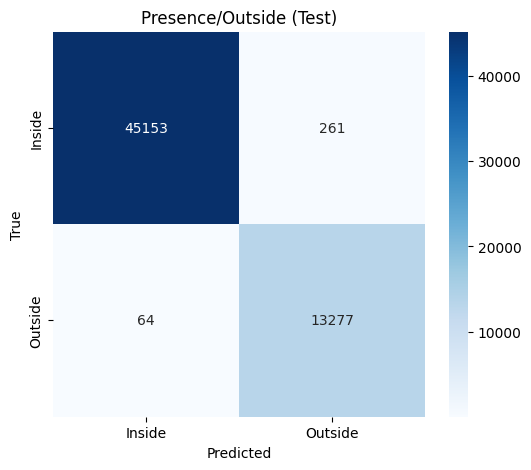


Classification report:
              precision    recall  f1-score   support

      Inside       1.00      0.99      1.00     45414
     Outside       0.98      1.00      0.99     13341

    accuracy                           0.99     58755
   macro avg       0.99      0.99      0.99     58755
weighted avg       0.99      0.99      0.99     58755



In [9]:
test_loss, test_acc = model_bin.evaluate(
    [X_sub_test_pca, X_sender_test, X_recv_test, X_meta_test_sc],
    y_test_bin,
    verbose=1
)
print(f"\nFinal Test Accuracy (presence vs outside): {test_acc:.6f}")


y_pred_probs_bin = model_bin.predict(
    [X_sub_test_pca, X_sender_test, X_recv_test, X_meta_test_sc],
    batch_size=64
)

y_pred_bin = (y_pred_probs_bin >= 0.5).astype(int)

true_str = ["Inside" if t == 1 else "Outside" for t in y_test_bin]
pred_str = ["Inside" if p == 1 else "Outside" for p in y_pred_bin]


print_confusion_matrix(true_str, pred_str, title="Presence/Outside (Test)")

print("\nClassification report:")
print(classification_report(true_str, pred_str))
